In [2]:

import numpy as np
from nilearn import datasets
from nilearn.input_data import NiftiLabelsMasker
from nilearn.image import index_img
import nibabel as nib
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from sklearn.mixture import GaussianMixture
# from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import seaborn as sns

brain_data = datasets.fetch_oasis_vbm(n_subjects=100)

     |████████████████████████████████| 10.0 MB 4.7 MB/s 


/usr/local/lib/python3.7/dist-packages/nilearn/datasets/__init__.py:96: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)



Dataset created in /root/nilearn_data/oasis1



Downloaded 886423552 of 905208634 bytes (97.9%,    0.7s remaining) ...done. (33 seconds, 0 min)
Extracting data from /root/nilearn_data/oasis1/adcb228c7b26ed4f4fba93bd32bf8d97/archive_dartel.tgz..... done.
/usr/local/lib/python3.7/dist-packages/numpy/lib/npyio.py:2349: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  output = genfromtxt(fname, **kwargs)


In [3]:
def plot_each_n_rois(i):
  yeo = datasets.fetch_atlas_schaefer_2018(n_rois=i)
  print('%i regions found in this atlas' % (len(np.unique(nib.load(yeo.maps).get_data().ravel())) 
  - 1))
  masker = NiftiLabelsMasker(labels_img=yeo.maps, standardize=True, 
  memory='nilearn_cache')
  input_variables = masker.fit_transform(brain_data.gray_matter_maps)
  output_variable = np.array(brain_data.ext_vars.mf == b'F', dtype=np.int) # gives 1 for females and 0 for males

  train_input = input_variables[:80]
  train_output = output_variable[:80]

  test_input = input_variables[80:]
  test_output = output_variable[80:]

  def plot_each_k_cluster(k):
    ### K-means ####
    kmeans = KMeans(n_clusters=k).fit(train_input) ### feature engineering on train_split
    kmeans_input_variables= kmeans.transform(input_variables)
    # kmeans_test_input = kmeans.transform(test_input)

    ### GMM ####
    GMM = GaussianMixture(n_components=k).fit(train_input) ### feature engineering on train_split
    gmm_input_variables = GMM.predict_proba(input_variables)
    # GMM_test_input = GMM.predict_proba(test_input)

    ### PCA ####
    pca = PCA(n_components=k).fit(train_input) ### feature engineering on train_split
    pca_input_variables = pca.transform(input_variables)
    # pca_test_input = pca.transform(test_input)

    ### ICA ####
    ica = FastICA(n_components=k).fit(train_input) ### feature engineering on train_split
    ica_input_variables = ica.transform(input_variables)
    # ica_test_input = ica.transform(test_input)

    kf = KFold(n_splits=5)

    km_accuracy = 0
    gmm_accuracy = 0
    pca_accuracy = 0
    ica_accuracy = 0
    
    km_train_accuracy = 0
    gmm_train_accuracy = 0
    pca_train_accuracy = 0
    ica_train_accuracy = 0

    for train_index, test_index in kf.split(output_variable):
      ######### KMeans #########
      kmeans_X_train, kmeans_X_test = kmeans_input_variables[train_index], kmeans_input_variables[test_index]
      y_train, y_test = output_variable[train_index], output_variable[test_index]

      kmeans_Logmodel = LogisticRegression(penalty='l2',C=1.0).fit(kmeans_X_train, y_train)
      kmeans_log_predict_output = kmeans_Logmodel.predict(kmeans_X_test)
      km_accuracy += np.sum(kmeans_log_predict_output == y_test)/len(y_test)

      kmeans_log_predict_output_tr = kmeans_Logmodel.predict(kmeans_X_train)
      km_train_accuracy += np.sum(kmeans_log_predict_output_tr == y_train)/len(y_train)

      ######### GMM #########
      gmm_X_train, gmm_X_test = gmm_input_variables[train_index], gmm_input_variables[test_index]
      y_train, y_test = output_variable[train_index], output_variable[test_index]

      gmm_Logmodel = LogisticRegression(penalty='l2',C=1.0).fit(gmm_X_train, y_train)
      gmm_log_predict_output = gmm_Logmodel.predict(gmm_X_test)
      gmm_accuracy += np.sum(gmm_log_predict_output == y_test)/len(y_test)

      gmm_log_predict_output_tr = gmm_Logmodel.predict(gmm_X_train)
      gmm_train_accuracy += np.sum(gmm_log_predict_output_tr == y_train)/len(y_train)

      ######### PCA #########
      pca_X_train, pca_X_test = pca_input_variables[train_index], pca_input_variables[test_index]
      y_train, y_test = output_variable[train_index], output_variable[test_index]

      pca_Logmodel = LogisticRegression(penalty='l2',C=1.0).fit(pca_X_train, y_train)
      pca_log_predict_output = pca_Logmodel.predict(pca_X_test)
      pca_accuracy += np.sum(pca_log_predict_output == y_test)/len(y_test)

      pca_log_predict_output_tr = pca_Logmodel.predict(pca_X_train)
      pca_train_accuracy += np.sum(pca_log_predict_output_tr == y_train)/len(y_train)

      ######### ICA #########
      ica_X_train, ica_X_test = ica_input_variables[train_index], ica_input_variables[test_index]
      y_train, y_test = output_variable[train_index], output_variable[test_index]

      ica_Logmodel = LogisticRegression(penalty='l2',C=1.0).fit(ica_X_train, y_train)
      ica_log_predict_output = ica_Logmodel.predict(ica_X_test)
      ica_accuracy += np.sum(ica_log_predict_output == y_test)/len(y_test)

      ica_log_predict_output_tr = ica_Logmodel.predict(ica_X_train)
      ica_train_accuracy += np.sum(ica_log_predict_output_tr == y_train)/len(y_train)

    return k, km_accuracy/5, gmm_accuracy/5, pca_accuracy/5, ica_accuracy/5, km_train_accuracy/5, gmm_train_accuracy/5, pca_train_accuracy/5, ica_train_accuracy/5
  
  y_list = [] ### k
  km_value_list = [] ### accuracy
  gmm_value_list = [] ### accuracy
  pca_value_list = [] ### accuracy
  ica_value_list = [] ### accuracy
  km_value_list_train = [] ### accuracy
  gmm_value_list_train = [] ### accuracy
  pca_value_list_train = [] ### accuracy
  ica_value_list_train = [] ### accuracy

  for k in range (1,11):
    k, km_accuracy, gmm_accuracy, pca_accuracy, ica_accuracy, km_train_accuracy, gmm_train_accuracy, pca_train_accuracy, ica_train_accuracy = plot_each_k_cluster(k)

    # print("i: ", i,"accuracy: ", accuracy)
    y_list.append(i)
    # log_y_list.append(log_accuracy)
    # KNN_y_list.append(KNN_accuracy)
    km_value_list.append(km_accuracy)
    gmm_value_list.append(gmm_accuracy)
    pca_value_list.append(pca_accuracy)
    ica_value_list.append(ica_accuracy)
    km_value_list_train.append(km_train_accuracy)
    gmm_value_list_train.append(gmm_train_accuracy)
    pca_value_list_train.append(pca_train_accuracy)
    ica_value_list_train.append(ica_train_accuracy)
  
  return i, km_value_list, gmm_value_list, pca_value_list, ica_value_list, km_value_list_train, gmm_value_list_train, pca_value_list_train, ica_value_list_train

In [4]:
x_list = [] ### n_rois
y_list = [1,2,3,4,5,6,7,8,9,10]
km_y_list = [] ### list of list of accuracy
gmm_y_list = [] ### list of list of accuracy
pca_y_list = [] ### list of list of accuracy
ica_y_list = [] ### list of list of accuracy
km_y_list_train = [] ### list of list of accuracy
gmm_y_list_train = [] ### list of list of accuracy
pca_y_list_train = [] ### list of list of accuracy
ica_y_list_train = [] ### list of list of accuracy

for i in range (100,1100,100):
  i, km_value_list, gmm_value_list, pca_value_list, ica_value_list, km_value_list_train, gmm_value_list_train, pca_value_list_train, ica_value_list_train = plot_each_n_rois(i)

  # print("i: ", i,"accuracy: ", accuracy)
  x_list.append(i)
  # log_y_list.append(log_accuracy)
  # KNN_y_list.append(KNN_accuracy)
  km_y_list.append(km_value_list)
  gmm_y_list.append(gmm_value_list)
  pca_y_list.append(pca_value_list)
  ica_y_list.append(ica_value_list)
  km_y_list_train.append(km_value_list_train)
  gmm_y_list_train.append(gmm_value_list_train)
  pca_y_list_train.append(pca_value_list_train)
  ica_y_list_train.append(ica_value_list_train)

km_y_list = np.array(km_y_list).transpose()
gmm_y_list = np.array(gmm_y_list).transpose()
pca_y_list = np.array(pca_y_list).transpose()
ica_y_list = np.array(ica_y_list).transpose()
km_y_list_train = np.array(km_y_list_train).transpose()
gmm_y_list_train = np.array(gmm_y_list_train).transpose()
pca_y_list_train = np.array(pca_y_list_train).transpose()
ica_y_list_train = np.array(ica_y_list_train).transpose()




Dataset created in /root/nilearn_data/schaefer_2018



 ...done. (0 seconds, 0 min)
 ...done. (0 seconds, 0 min)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  This is separate from the ipykernel package so we can avoid doing imports until


100 regions found in this atlas


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation fo

 ...done. (0 seconds, 0 min)
 ...done. (0 seconds, 0 min)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  This is separate from the ipykernel package so we can avoid doing imports until


200 regions found in this atlas


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
   

 ...done. (0 seconds, 0 min)
 ...done. (0 seconds, 0 min)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  This is separate from the ipykernel package so we can avoid doing imports until


300 regions found in this atlas


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


 ...done. (0 seconds, 0 min)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  This is separate from the ipykernel package so we can avoid doing imports until


400 regions found in this atlas


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
   

 ...done. (0 seconds, 0 min)
 ...done. (0 seconds, 0 min)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  This is separate from the ipykernel package so we can avoid doing imports until


500 regions found in this atlas


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


 ...done. (0 seconds, 0 min)
 ...done. (0 seconds, 0 min)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  This is separate from the ipykernel package so we can avoid doing imports until


600 regions found in this atlas


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


 ...done. (0 seconds, 0 min)
 ...done. (0 seconds, 0 min)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  This is separate from the ipykernel package so we can avoid doing imports until


700 regions found in this atlas


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


 ...done. (0 seconds, 0 min)
 ...done. (0 seconds, 0 min)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  This is separate from the ipykernel package so we can avoid doing imports until


800 regions found in this atlas


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


 ...done. (0 seconds, 0 min)
 ...done. (0 seconds, 0 min)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  This is separate from the ipykernel package so we can avoid doing imports until


900 regions found in this atlas


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
   

 ...done. (0 seconds, 0 min)
 ...done. (0 seconds, 0 min)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  This is separate from the ipykernel package so we can avoid doing imports until


1000 regions found in this atlas


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Text(0.5, 1.0, 'ICA Accuracy on Train Set')

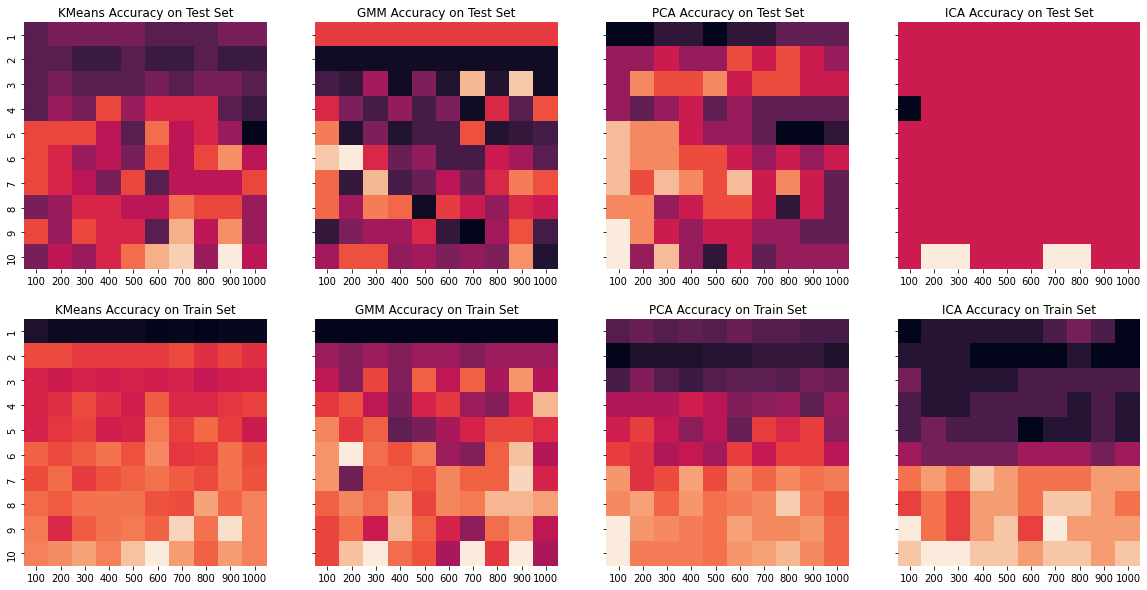

In [5]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10), sharey=True)

ax_km_y_list = sns.heatmap(km_y_list,xticklabels=x_list, yticklabels=y_list,cbar=False,ax=axes[0,0])
ax_gmm_y_list = sns.heatmap(gmm_y_list, xticklabels=x_list, yticklabels=y_list,cbar=False,ax=axes[0,1])
ax_pca_y_list = sns.heatmap(pca_y_list, xticklabels=x_list, yticklabels=y_list,cbar=False,ax=axes[0,2])
ax_ica_y_list = sns.heatmap(ica_y_list, xticklabels=x_list, yticklabels=y_list,cbar=False,ax=axes[0,3])
ax_km_y_list_train = sns.heatmap(km_y_list_train, xticklabels=x_list, yticklabels=y_list,cbar=False,ax=axes[1,0])
ax_gmm_y_list_train = sns.heatmap(gmm_y_list_train, xticklabels=x_list, yticklabels=y_list,cbar=False,ax=axes[1,1])
ax_pca_y_list_train = sns.heatmap(pca_y_list_train, xticklabels=x_list, yticklabels=y_list,cbar=False,ax=axes[1,2])
ax_ica_y_list_train = sns.heatmap(ica_y_list_train, xticklabels=x_list, yticklabels=y_list,cbar=False,ax=axes[1,3])

ax_km_y_list.set_title('KMeans Accuracy on Test Set')
ax_gmm_y_list.set_title('GMM Accuracy on Test Set')
ax_pca_y_list.set_title('PCA Accuracy on Test Set')
ax_ica_y_list.set_title('ICA Accuracy on Test Set')
ax_km_y_list_train.set_title('KMeans Accuracy on Train Set')
ax_gmm_y_list_train.set_title('GMM Accuracy on Train Set')
ax_pca_y_list_train.set_title('PCA Accuracy on Train Set')
ax_ica_y_list_train.set_title('ICA Accuracy on Train Set')

In [6]:
plt.show()